# Tarea 6 P1 ~ Stauber Daniela
##  1D elliptic self adjoint eigenvalue problem
Resolveremos un problema de la forma

$$ -\frac{d}{dx}(p(x)\frac{d}{dx}u) + q(x) u(x) = \lambda r(x) u(x)$$

con $p(x) > 0$ y condiciones de borde$\{u_0=0, u_1=0\}$ en ambos extremos. 

In [1]:
using Gridap
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
using gmsh
using LinearAlgebra
using SparseArrays
using SuiteSparse
using Arpack


In [2]:
include("models/mesh_generator.jl")


make_model (generic function with 1 method)

Trabajaré en esta parte con el Test 3 

#### Test 1 is just the second derivatives (p=1, q=0, r=1)
The solutions are $u_n = sin(n*x)$ in the interval $[0,\pi]$, and the eigenvalues are $\lambda_n = n^2$.

#### Test 2 has (p=x, q=0, r=1/x)
The solutions are: $(\lambda = (\frac{n\pi}{\ln L})^2\;\;\;\; n>0, u_n = \sin(\frac{n\pi}{\ln L}\ln x)$, in the interval $[1,L]$.

#### Test 3 the harmonic oscillator (p=1, q=x^2, r=1)
The solutions are: $(\lambda = 1 + 2n, \;\;\; n\geq 0, u_n = e^{-x^2/2}H_n)$, where $H_n$ are the Hermite polynomials.


In [3]:
test_1 = false 
test_2 = false
#test_3 = false
#test_1 = true
#test_2 = true 
test_3 = true 


true

Define an equi-spaced grid with N nodes of length L

In [5]:
# Create mesh with N point

if test_1 
    
    grid_type = "1D"
    h = 1/200
    par = (0,π, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0

elseif test_2
    
    grid_type = "1D"
    h = 1/200
    L = 2
    par = (1,L, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
elseif test_3
    
    grid_type = "1D"
    h = 1/200
    par = (-10,10, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
else
    
    grid_type = "1D"
    h = 1/1000
    par = (0.,20., h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["left", "right"]
    dirichlet_tags= ["left", "right"]
    dirichlet_values = [0.0,0.0] # 0.0+im*0.0
    
end

model = make_model(grid_type, par)


Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000998735s, CPU 0s)
Info    : 4001 nodes 4002 elements
Info    : Writing 'models/1D.msh'...
Info    : Done writing 'models/1D.msh'
Info    : Reading 'models/1D.msh'...
Info    : 3 entities
Info    : 4001 nodes
Info    : 4002 elements
Info    : Done reading 'models/1D.msh'


UnstructuredDiscreteModel()

In [6]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)


Measure()

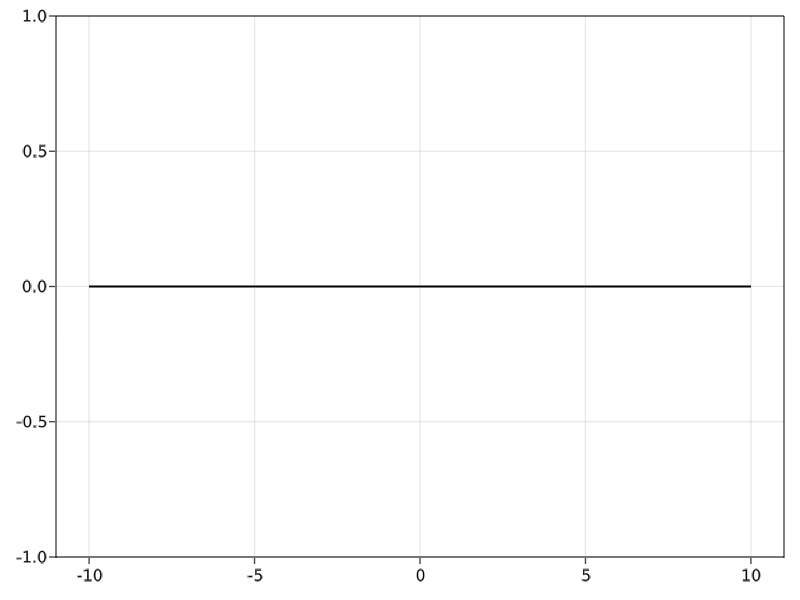

In [7]:
fig, ax = plot(Ω)
#scatter!(Ω, marker=:star8, markersize=4, color=:blue)
wireframe!(Ω, color=:black, linewidth=2)
fig


In [15]:
#Γ = BoundaryTriangulation(model,tags=boundary_tags)
#dΓ = Measure(Γ,degree)
#fig, ax = plot(Γ, linewidth=8)
#ax.aspect = AxisAspect(1)
#wireframe!(Γ, color=:black, linewidth=1)
#fig

In [7]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)

V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
U = TrialFESpace(V,dirichlet_values)


TrialFESpace()

In [9]:
#cambiamos el signo de p con respecto a la definición anterior
if test_1
    p(x) = 1
    q(x) = 0
    r(x) = 1
elseif test_2
    p(x) = x[1]
    q(x) = 0
    r(x) = 1/x[1]
elseif test_3
    p(x) = 1
    q(x) = x[1]*x[1]
    r(x) = 1
else
    p(x) = (1 + x[1] + 0.5*x[1]*x[1])/(10 + 0.5*x[1]*x[1]) # don't remember this potential...
    q(x) = -10*x[1]/(1 + 5*x[1]*x[1])
    r(x) = 1
end


r (generic function with 1 method)

Graficamos las funciones de la ec dif

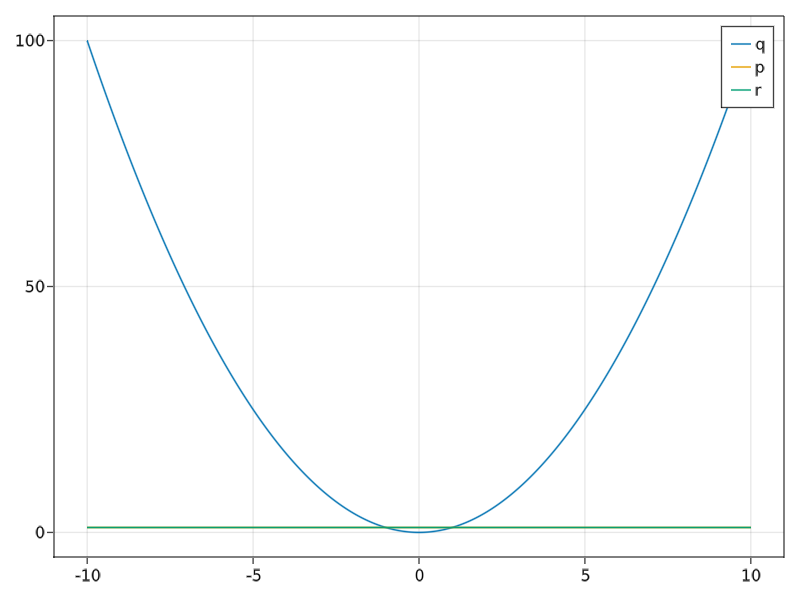

In [10]:
x = range(par[1], par[2], length=4000)
yq = q.(x)
yp = p.(x)
yr = r.(x)
lines(x, yq, label= "q")
lines!(x, yp, label= "p")
lines!(x, yr, label= "r")
axislegend()
current_figure()


Definimos el problema variacional

In [11]:
a(u,v) = ∫(p*∇(v)⋅∇(u) + q*v*u)*dΩ
m(u,v) = ∫(r*u*v)dΩ


m (generic function with 1 method)

Inlcuimos el note de resolución

In [12]:
include("eigen.jl")


solve (generic function with 1 method)

Resolvemos

In [13]:
nev = 5 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev=nev, tol=10^(-10), maxiter=100, explicittransform=:none, sigma=-1.0)
#prob = EigenProblem(a, m, U, V; nev=nev, which=:LM, explicittransform=:auto, tol=10^(-6), maxiter=100, sigma=0)
ξ, uₕs = solve(prob);


Ilustraremos los resultados y los compararemos con los exactos

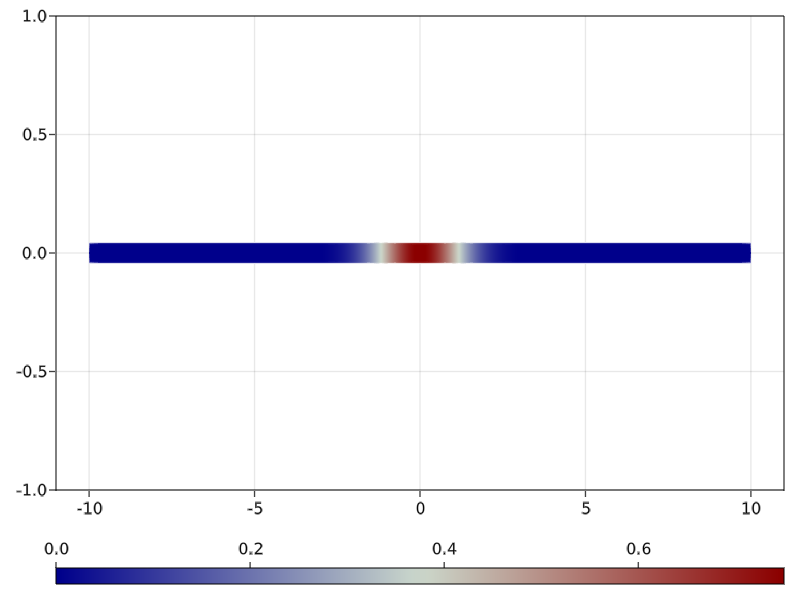

In [14]:
uₕ = uₕs[1]
fig, ax, plt = plot(Ω, real(uₕ), linewidth=20)
#ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

In [15]:
u=(uₕs[1],uₕs[2], uₕs[3],uₕs[4],uₕs[5])

(SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction())

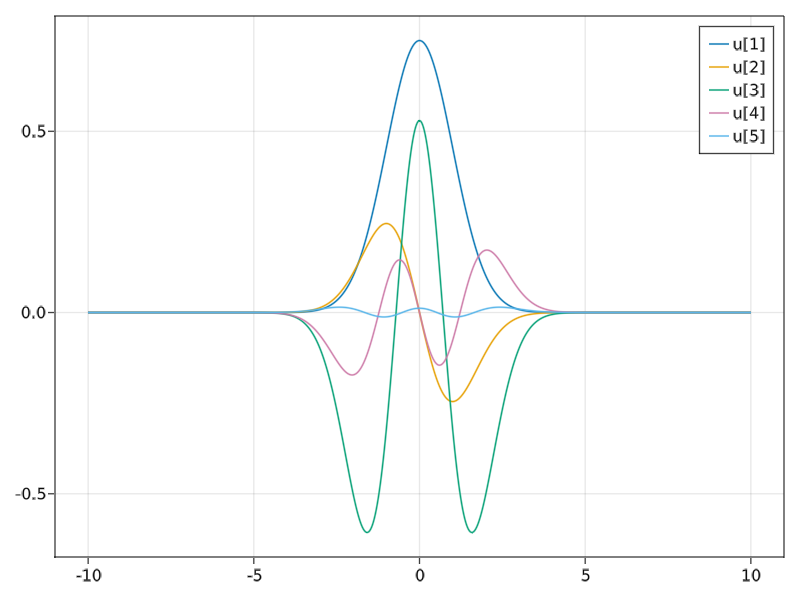

In [16]:

x = range(par[1], par[2], length=4000)
lines(x, evaluate(real(u[1]),Gridap.Point.(x)), label= "u[1]")
lines!(x, evaluate(real(u[2]),Gridap.Point.(x)), label= "u[2]")
lines!(x, evaluate(real(u[3]),Gridap.Point.(x)), label= "u[3]")
lines!(x, evaluate(real(u[4]),Gridap.Point.(x)), label= "u[4]")
lines!(x, evaluate(real(u[5]),Gridap.Point.(x)), label= "u[5]")
axislegend()
current_figure() 


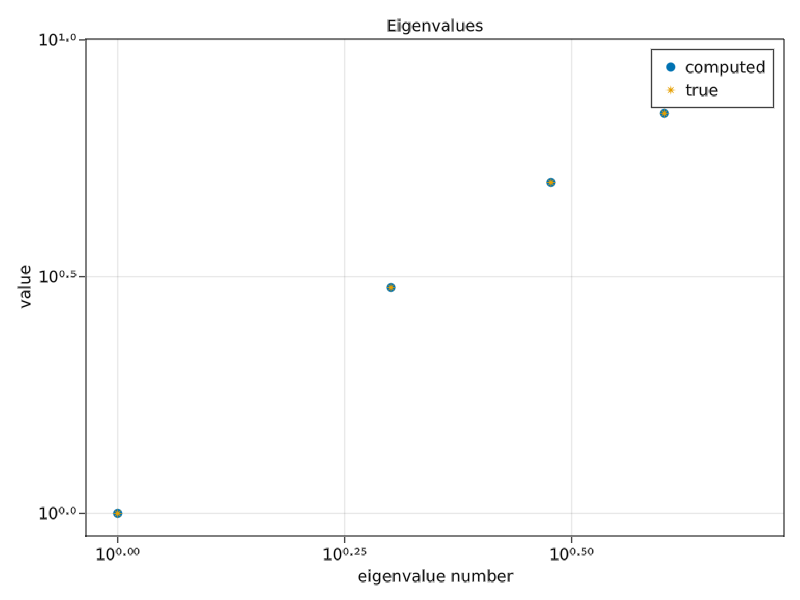

In [17]:
fig = Figure()

ax = Axis(fig[1, 1], xlabel = "eigenvalue number", ylabel = "value",
    title = "Eigenvalues", yscale = log10, xscale = log10)

scatter!(sort(real(ξ[1:nev])), label = "computed")

if test_1
    scatter!(ax,[n^2 for n ∈ 1:nev], marker=:star8, label = "true")
elseif test_2
    scatter!([(n*π/log(L))^2 for n ∈ 1:nev], marker=:star8, label = "true")
elseif test_3
    scatter!([1 + 2*(n-1) for n ∈ 1:nev], marker=:star8, label = "true")
end
axislegend()
current_figure()
fig

In [18]:
ξ

5-element Vector{ComplexF64}:
  1.000000000007685 - 3.159228003539195e-16im
 3.0000000000264873 - 1.6668621586197889e-15im
  5.000000000086282 - 3.165867113701447e-16im
  7.000000000210639 + 1.6240576342424407e-15im
  9.000000000426953 + 1.2563913164340088e-15im

And here we can save them into a file to see it with visit, for instance. 

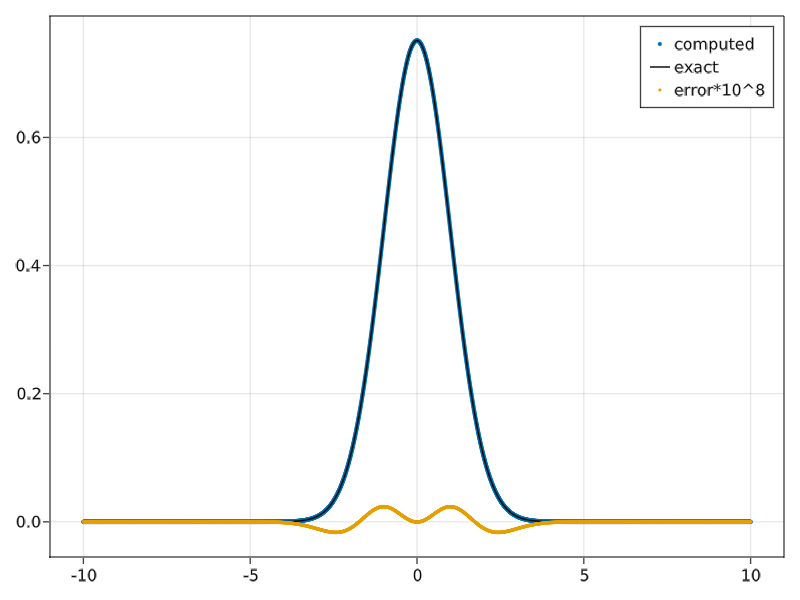

In [19]:
n=1 # for test_3 use n=4

uₕ = u[n]
# normalize the eigenvalue
u2 = sum(∫(uₕ*uₕ)*dΩ)
uₕ = uₕ/sqrt(u2)

if test_1
    u_n(x) = -sin(n*x)/sqrt(π/2)
elseif test_2
    freq=n*π/log(L)
    u_n(x) = sqrt((4*freq^2+1)/(2(L-1)*freq^2))*sin(freq*log(x))
elseif test_3
    u_n(x) = exp(-x^2/2)/sqrt(sqrt(π))
end

x = range(par[1], par[2], length=4000)
scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "computed",markersize = 4)
lines!(x, u_n.(x), label= "exact", color = :black)
scatter!(x, (evaluate(real(uₕ),Gridap.Point.(x))-u_n.(x))*100000000, label= "error*10^8", markersize = 3)
axislegend()
current_figure()        

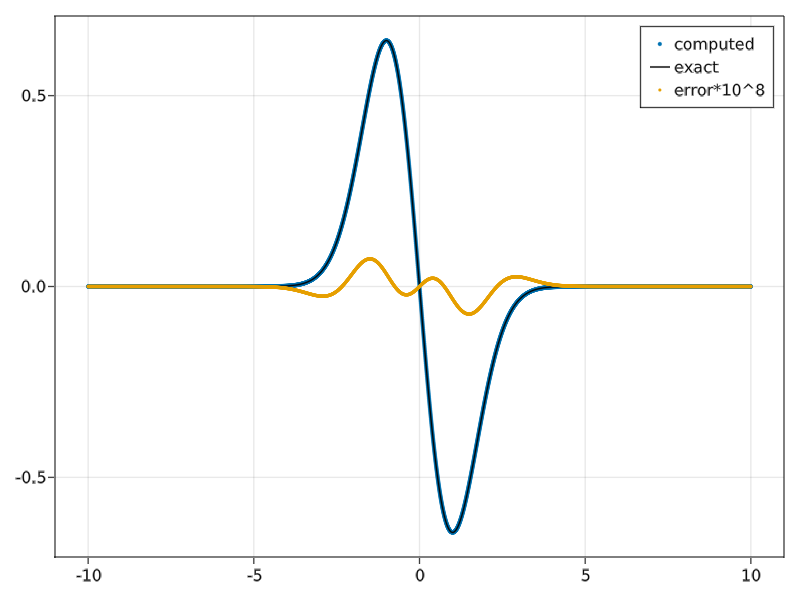

In [20]:
n=2 # for test_3 use n=4

uₕ = u[n]
# normalize the eigenvalue
u2 = sum(∫(uₕ*uₕ)*dΩ)
uₕ = uₕ/sqrt(u2)

if test_1
    u_n(x) = -sin(n*x)/sqrt(π/2)
elseif test_2
    freq=n*π/log(L)
    u_n(x) = sqrt((4*freq^2+1)/(2(L-1)*freq^2))*sin(freq*log(x))
elseif test_3
    u_n(x) = (-exp(-x^2/2)*2*x)/sqrt(4. * (sqrt(π)/2 - 10. /exp(100)))
end

x = range(par[1], par[2], length=4000)
scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "computed",markersize = 4)
lines!(x, u_n.(x), label= "exact", color = :black)
scatter!(x, (evaluate(real(uₕ),Gridap.Point.(x))-u_n.(x))*100000000, label= "error*10^8", markersize = 3)
axislegend()
current_figure()    

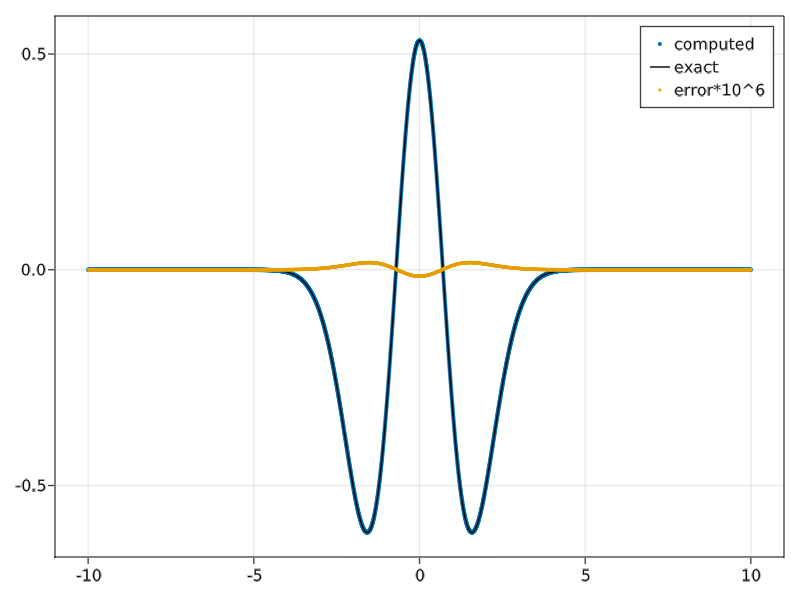

In [21]:
n=3 # for test_3 use n=4

uₕ = u[n]
# normalize the eigenvalue
u2 = sum(∫(uₕ*uₕ)*dΩ)
uₕ = uₕ/sqrt(u2)

if test_1
    u_n(x) = -sin(n*x)/sqrt(π/2)
elseif test_2
    freq=n*π/log(L)
    u_n(x) = sqrt((4*freq^2+1)/(2(L-1)*freq^2))*sin(freq*log(x))
elseif test_3
    u_n(x) = -(exp(-x^2/2)*(4*x^2-2.))/sqrt(14.17963)
end

x = range(par[1], par[2], length=4000)
scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "computed",markersize = 4)
lines!(x, u_n.(x), label= "exact", color = :black)
scatter!(x, (evaluate(real(uₕ),Gridap.Point.(x))-u_n.(x))*1000000, label= "error*10^6", markersize = 3)
axislegend()
current_figure() 

## Estudiemos el método con otro problema
Estudiare la ecuacion de autovalores
$$ -\frac{d}{dx}[x^2 u(x)]= \lambda u(x)$$ es decir  tenemos
$$p(x)=x^2 \text{,    }q(x)=0 \text{,    } r(x)=1$$
Donde con $ \lambda > \frac{1}{4}$ tenemos por solución $$u(x)=x^{\alpha} \sin(\beta \ln(x))$$ donde
$\alpha= -\frac{1}{2}$, $\beta=\sqrt{\frac{4\lambda_n -1}{2}}$ con $\lambda_n =\frac{1}{4}+ (\frac{n \pi}{\ln(2)})^2 \text{ ,   } n>0$ 

In [4]:
include("models/mesh_generator.jl")


make_model (generic function with 1 method)

In [8]:
h=1/2000
grid_type = "1D"
par = (1. ,2. , h) #for test (Length_x, Length_y, h) E
boundary_tags = ["left", "right"]
dirichlet_tags= ["left", "right"]
dirichlet_values = [0.,0.] # 0.0+im*0.0
model = make_model(grid_type, par)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0s, CPU 0s)
Info    : 2001 nodes 2002 elements
Info    : Writing 'models/1D.msh'...
Info    : Done writing 'models/1D.msh'
Info    : Reading 'models/1D.msh'...
Info    : 3 entities
Info    : 2001 nodes
Info    : 2002 elements
Info    : Done reading 'models/1D.msh'


UnstructuredDiscreteModel()

In [9]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

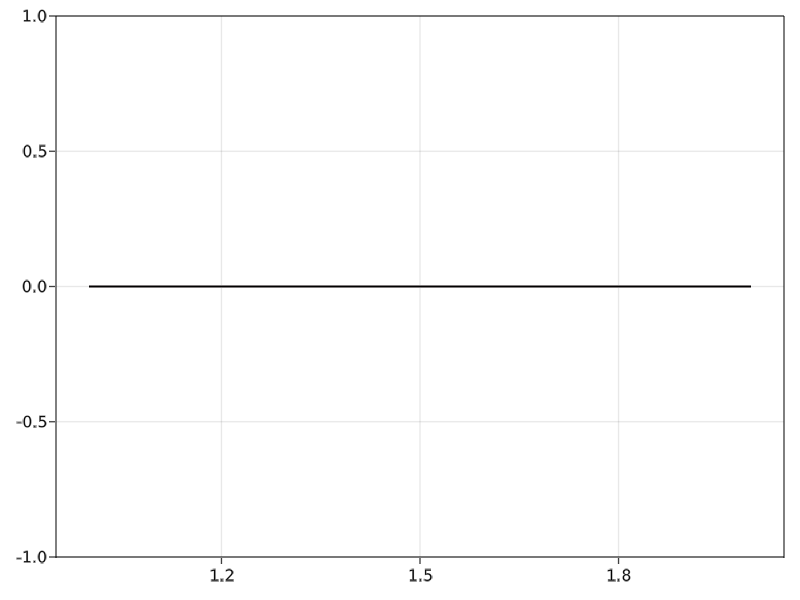

In [10]:
fig, ax = plot(Ω)
#scatter!(Ω, marker=:star8, markersize=4, color=:blue)
wireframe!(Ω, color=:black, linewidth=2)
fig


In [11]:
p(x) = x[1]*x[1]
q(x) = 0.
r(x) = 1.

r (generic function with 1 method)

In [12]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)

V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
U = TrialFESpace(V,dirichlet_values)

TrialFESpace()

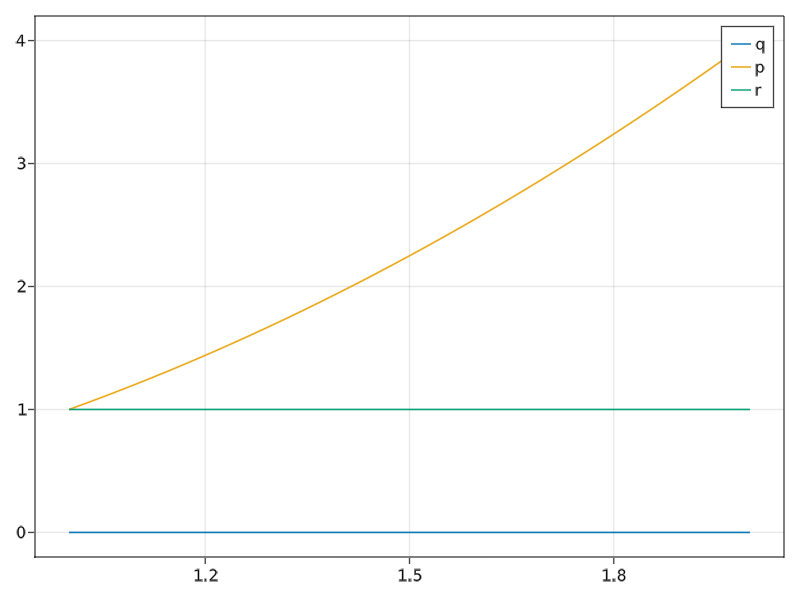

In [13]:
x = range(par[1], par[2], length=4000)
yq = q.(x)
yp = p.(x)
yr = r.(x)
lines(x, yq, label= "q")
lines!(x, yp, label= "p")
lines!(x, yr, label= "r")
axislegend()
current_figure()

In [14]:
a(u,v) = ∫(p*∇(v)⋅∇(u) + q*v*u)*dΩ
m(u,v) = ∫(r*u*v)dΩ

m (generic function with 1 method)

In [15]:
include("eigen.jl")

solve (generic function with 1 method)

In [26]:
nev = 6 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev=nev, tol=10^(-10), maxiter=100, explicittransform=:none, sigma=-1.0)
#prob = EigenProblem(a, m, U, V; nev=nev, which=:LM, explicittransform=:auto, tol=10^(-6), maxiter=100, sigma=0)
ξ, uₕs = solve(prob);


In [27]:
u=(uₕs[1],uₕs[2],uₕs[3], uₕs[4],uₕs[5],uₕs[6])

(SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction())

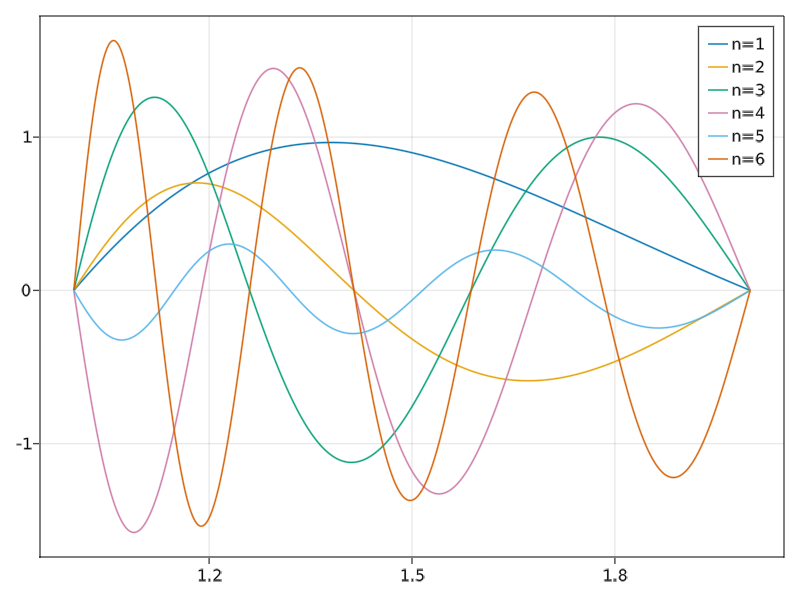

In [48]:
x = range(par[1], par[2], length=2000)
lines(x, evaluate(real(u[1]),Gridap.Point.(x)), label= "n=1")
lines!(x, evaluate(real(u[2]),Gridap.Point.(x)), label= "n=2")
lines!(x, evaluate(real(u[3]),Gridap.Point.(x)), label= "n=3")
lines!(x, evaluate(real(u[4]),Gridap.Point.(x)), label= "n=4")
lines!(x, evaluate(real(u[5]),Gridap.Point.(x)), label= "n=5")
lines!(x, evaluate(real(u[6]),Gridap.Point.(x)), label= "n=6")
axislegend()
current_figure() 

In [30]:
ξ

6-element Vector{ComplexF64}:
 20.79228845871901 + 3.3834769591030777e-14im
 82.41915382385947 - 2.130305621966101e-12im
 185.1305961015536 - 6.586981395969043e-12im
 328.9266152898412 - 9.783076470287158e-12im
 513.8072113923697 + 7.742666095313143e-11im
 739.7723844153679 - 4.238960147160049e-11im

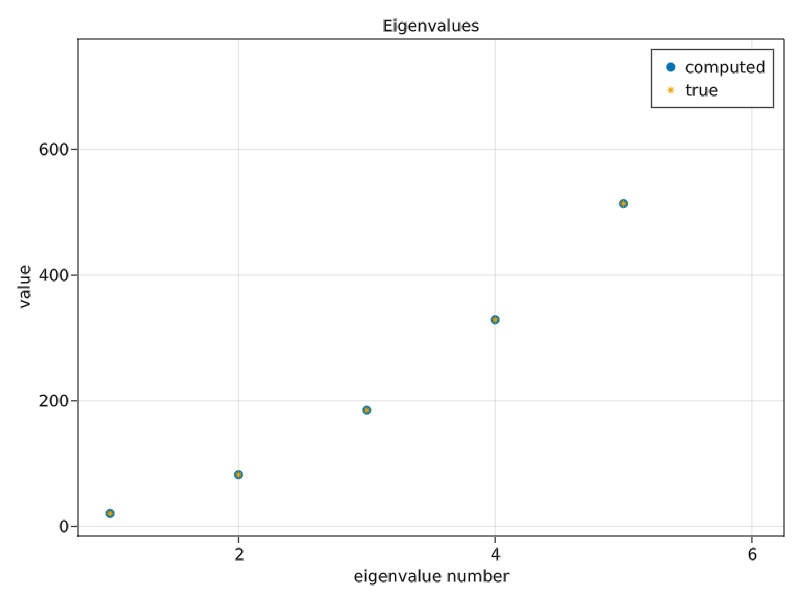

In [46]:

fig = Figure()

ax = Axis(fig[1, 1], xlabel = "eigenvalue number", ylabel = "value",
    title = "Eigenvalues", legend = :bottomright)

scatter!(sort(real(ξ[1:nev])), label = "computed")


scatter!(ax,[0.25+(n*π/log(2))^2 for n ∈ 1:nev], marker=:star8, label = "true")

axislegend()
current_figure()
fig

In [77]:
6.409725182676557 *log(2)

4.442882938536336

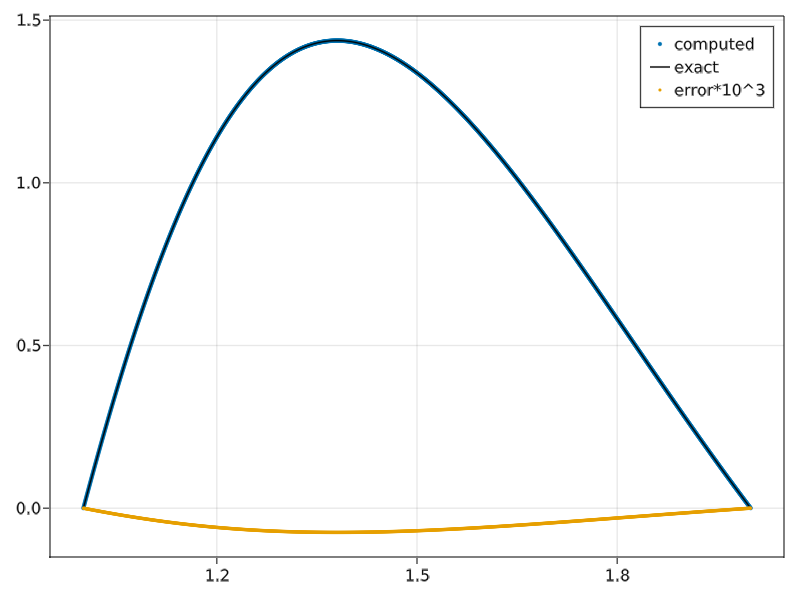

GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: La operación se completó correctamente. 
Stacktrace:
 [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
   @ GLFW C:\Users\LENOVO\.julia\packages\GLFW\BWxfF\src\callback.jl:43
 [2] MakeContextCurrent
   @ C:\Users\LENOVO\.julia\packages\GLFW\BWxfF\src\glfw3.jl:694 [inlined]
 [3] make_context_current
   @ C:\Users\LENOVO\.julia\packages\GLMakie\lcQNS\src\drawing_primitives.jl:46 [inlined]
 [4] fps_renderloop(screen::GLMakie.Screen, framerate::Float64)
   @ GLMakie C:\Users\LENOVO\.julia\packages\GLMakie\lcQNS\src\rendering.jl:26
 [5] renderloop(screen::GLMakie.Screen; framerate::Float64)
   @ GLMakie C:\Users\LENOVO\.julia\packages\GLMakie\lcQNS\src\rendering.jl:48
 [6] renderloop(screen::GLMakie.Screen)
   @ GLMakie C:\Users\LENOVO\.julia\packages\GLMakie\lcQNS\src\rendering.jl:41
 [7] (::GLMakie.var"#50#52"{GLMakie.Screen})()
   @ GLMakie .\task.jl:411


In [86]:
n=1 # for test_3 use n=4

uₕ = u[n]
# normalize the eigenvalue
u2 = sum(∫(uₕ*uₕ)*dΩ)
uₕ = uₕ/sqrt(u2)

α=-1/2
β=sqrt((4*real(ξ[1]) -1.))/2
u_n(x) = x[1]^α * sin(β*log(x[1]))/ sqrt(0.34657)


x = range(par[1], par[2], length=2000)
scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "computed",markersize = 4)
lines!(x, u_n.(x), label= "exact", color = :black)
scatter!(x, (evaluate(real(uₕ),Gridap.Point.(x))-u_n.(x))*10000, label= "error*10^3", markersize = 3)
axislegend()
current_figure() 